# Predictor automático de precio de autos
El servicio de venta de autos usados Rusty Bargain está desarrollando una aplicación para atraer nuevos clientes. Gracias a esa app, puedes averiguar rápidamente el valor de mercado de tu coche. El objetivo es  crear un modelo que determine el valor de mercado. Se cuenta con especificaciones técnicas, versiones de equipamiento y precios. 

Se comparan tres tipos de modelos y se evalúan:
- la calidad de la predicción;
- la velocidad de la predicción;
- el tiempo requerido para el entrenamiento

## Inicialización 

In [1]:
# manejo de datos
#---------------------------
import numpy as np
import pandas as pd

import math
import scipy 
import datetime

# visualización
#---------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# pre-procesamiento
#---------------------------
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# modelos
#---------------------------
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

# evaluación
#---------------------------
from sklearn.metrics import  mean_squared_error, r2_score
import time

## Inspección inicial de datos

Se importan los datos

In [2]:
data = pd.read_csv('/datasets/car_data.csv')

Se muestra la información general del dataframe y una muestra de los datos.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
data.sample(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
338405,09/03/2016 02:57,9990,sedan,2003,auto,260,e_klasse,150000,9,gasoline,mercedes_benz,no,09/03/2016 00:00,0,23558,20/03/2016 21:47
307737,30/03/2016 18:51,18000,coupe,2011,manual,160,tt,40000,3,petrol,audi,no,30/03/2016 00:00,0,29386,07/04/2016 10:17
29630,17/03/2016 10:51,920,small,1998,manual,54,corsa,150000,5,petrol,opel,no,17/03/2016 00:00,0,44866,25/03/2016 10:47
122590,05/04/2016 09:48,1666,sedan,1999,manual,155,other,150000,6,petrol,alfa_romeo,no,05/04/2016 00:00,0,25821,07/04/2016 12:17
204653,16/03/2016 18:42,2400,sedan,2003,manual,75,golf,125000,7,petrol,volkswagen,no,16/03/2016 00:00,0,97080,21/03/2016 21:49


Se tienen  354,369 filas con 16 columnas corresponientes a:

- DateCrawled: fecha en la que se descargó el perfil de la base de datos.
- Price: precio (en euros)
- VehicleType: tipo de carrocería del vehículo
- RegistrationYear: año de matriculación del vehículo
- Gearbox: tipo de caja de cambios
- Power: potencia (CV)
- Model: modelo del vehículo
- Mileage: kilometraje (medido en km de acuerdo con las especificidades regionales del conjunto de datos)
- RegistrationMonth: mes de matriculación del vehículo
- FuelType: tipo de combustible
- Brand:  marca del vehículo
- NotRepaired: vehículo con o sin reparación
- DateCreated: fecha de creación del perfil
- NumberOfPictures: número de fotos del vehículo
- PostalCode: código postal del propietario del perfil (usuario)
- LastSeen: fecha de la última vez que el usuario estuvo activo

### Tipo de datos.

La columna DateCrawled es la fecha en la que se descargó el perfil a la base de datos. En principio no representa una característica de la publicación o el auto por lo cual no debería afectar el precio, por lo cual la descartamos del análisis.

In [5]:
data = data.drop(columns=['DateCrawled'])

El resto de las columnas correspondientes a fechas se cambian a formato TimeStamp, y luego a entero para posteriormente facilitar el preprocesamiento de los datos.

In [6]:
col_dates = ['DateCreated', 'LastSeen']

for col in col_dates:
    data[col] = pd.to_datetime(data[col] , format='%d/%m/%Y %H:%M').astype('int')

Por otro lado podemos considerar a la columna 'PostalCode' como variable categórica, pues los números no representan parámetros cuantitativos.

In [7]:
data['PostalCode'] = data['PostalCode'].astype('str')

La columna 'NotRepaired' puede ser considerada como una categoria ordinal, pues, a grandes rasgos un auto que no ha tenido reparaciones tiene mayor valor en el mercado que un auto con reparaciones. Por lo cual podemos reemplazar los valores 'yes' con 1 y 'no' con 0.

In [8]:
data['NotRepaired'] = data['NotRepaired'].replace({'yes': 1, 'no':0})

### Datos duplicados

El número de filas duplicadas es:

In [9]:
data.duplicated().sum()

1024

Lo cual representa en porcentaje del total de datos:

In [10]:
print(round((data.duplicated().sum() *100) /data.shape[0] ,2), '%')

0.29 %


El número de datos duplicados es mínimo respecto a la muestra, por lo cual se procede a descartarlos y reiniciar los índices.

In [11]:
data = data.drop_duplicates().reset_index(drop=True)

### Datos ausentes

A continuación se muestra el porcentaje de datos ausentes por columna:

In [12]:
round(data.isna().sum()/data.shape[0] * 100, 2)

Price                 0.00
VehicleType          10.60
RegistrationYear      0.00
Gearbox               5.61
Power                 0.00
Model                 5.57
Mileage               0.00
RegistrationMonth     0.00
FuelType              9.30
Brand                 0.00
NotRepaired          20.12
DateCreated           0.00
NumberOfPictures      0.00
PostalCode            0.00
LastSeen              0.00
dtype: float64

Hay campos ausentes en las columnas VehicleType, Gearbox, Model, FuelType, NotRepaired. De estas columnas, las cuatro primeras son categóricas nominales, por lo cual rellenamos los campos con la cadena 'unknown'.

In [13]:
data[['VehicleType', 'Model', 'FuelType', 'Gearbox']] = data[['VehicleType', 'Model', 'FuelType', 'Gearbox']].fillna(value='unknown')

Alrededor del 20% de los valores de la columna NotRepaired están ausentes. En este caso rellenaremos los valores ausentes con el valor -1, asumiendo que el no tener esta información en la publicación afectará negativamente el valor del auto. Una vez que hemos hecho esto podemos cambiar el tipo de dato a entero.

In [14]:
data['NotRepaired'] = data['NotRepaired'].fillna(value=-1).astype('int')

### Descripción de datos

A continuación se muestran las estadísticas descriptivas de las columnas numéricas para detectar incongruencias y hacer observaciones generales. 

In [15]:
data.describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NotRepaired,DateCreated,NumberOfPictures,LastSeen
count,353345.000000,353345.000000,353345.000000,353345.000000,353345.000000,353345.000000,3.533450e+05,353345.0,3.533450e+05
mean,4414.561151,2004.237844,110.075026,128215.936266,5.712963,-0.099365,1.458501e+18,0.0,1.459295e+18
std,4513.809158,90.357965,190.101226,37909.709558,3.727041,0.541487,8.110154e+14,0.0,7.933409e+14
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,-1.000000,1.394410e+18,0.0,1.457187e+18
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.000000,1.457827e+18,0.0,1.458701e+18
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.000000,1.458518e+18,0.0,1.459695e+18
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.000000,1.459210e+18,0.0,1.459936e+18
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,1.000000,1.459987e+18,0.0,1.460041e+18


A primera vista se detectan las siguientes incongruencias:

 · Todos los valores de la columna NumberOfPictures son cero.
 
 · La columna RegistrationMonth	va de 0 a 12. No queda claro cuál es el mes 0.
 
 · El rango para año de registro de matriculación va de 1000 a 9999. Este rango parece no tener sentido, considerando que las fechas de descarga y última vista sólo van hasta el año 2016.
 
 · El valor máximo en la columna Power difere significativamente del resto. La mayoría de los resultados son menores a 150 CV.

Debido a que la columna NumberOfPictures no aporta información reelevante se procede a descartarla.

In [16]:
data = data.drop(columns=['NumberOfPictures'])

El mes de matriculación tiene sentido para valores de 1 a 12. Es posible que el valor cero represente falta de información. Como el valor no es muy alejado del resto no afecta el escalamiento, por lo tanto se deja así por el momento.

Es posible que existan valores anómalos en los años de matriculación, pueden deberse a errores de captura. A continuación se muestran los valores mayores a 2024 y menores a 1800.

In [17]:
sum(data['RegistrationYear'] > 2024) + sum(data['RegistrationYear'] < 1800)

166

Estos valores son pocos en comparación con la muestra. Además estos datos atípicos pueden afectar el proceso de escalamiento y sesgar los resultados. Por lo tanto se procede a reemplazarlos por la mediana: 2003.

In [18]:
data['RegistrationYear'] = data['RegistrationYear'].where( (data['RegistrationYear'] < 2024) & (data['RegistrationYear'] >= 1800), other=2003 )

A la fecha la potencia máxima de un auto es 5007hp, aproximadamente lo mismo en CV, mientras que los autos con mayor potencia del mercado en la actualidad tienen alrededor de 2300CV. Por lo cual valores superiores deben ser un error. El número de publicaciones con valores superiores son:

In [19]:
sum(data['Power'] > 2400) 

101

Por las mismas razones de la situación anterior, se reemplazan estos valores por la mediana: 105.

In [20]:
data['Power'] = data['Power'].where( (data['Power'] < 2400) , other=105 )

Una vez hechos los cambios, las estadísticas son:

In [21]:
data.describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NotRepaired,DateCreated,LastSeen
count,353345.000000,353345.00000,353345.000000,353345.000000,353345.000000,353345.000000,3.533450e+05,3.533450e+05
mean,4414.561151,2003.08194,107.413423,128215.936266,5.712963,-0.099365,1.458501e+18,1.459295e+18
std,4513.809158,7.57672,73.189344,37909.709558,3.727041,0.541487,8.110154e+14,7.933409e+14
min,0.000000,1800.00000,0.000000,5000.000000,0.000000,-1.000000,1.394410e+18,1.457187e+18
25%,1050.000000,1999.00000,69.000000,125000.000000,3.000000,0.000000,1.457827e+18,1.458701e+18
50%,2700.000000,2003.00000,105.000000,150000.000000,6.000000,0.000000,1.458518e+18,1.459695e+18
75%,6400.000000,2008.00000,142.000000,150000.000000,9.000000,0.000000,1.459210e+18,1.459936e+18
max,20000.000000,2019.00000,2389.000000,150000.000000,12.000000,1.000000,1.459987e+18,1.460041e+18


El precio de los vehículos va de 0 a 20,000 euros. El precio promedio ronda los 4 mil euros. Los datos de precio parecen congruentes.

Los autos registrados tienen kilometraje que va desde los 5,000 a 150,000 kilómetros. El promedio ronda los 13 mil km.

El resto de las columnas ahora tienen valores congruentes.

Finalmente se muestran las estadísticas de las columnas categóricas. 

In [22]:
data.describe(include=np.object)

,VehicleType,Gearbox,Model,FuelType,Brand,PostalCode
count,353345,353345,353345,353345,353345,353345
unique,9,3,251,8,40,8143
top,sedan,manual,golf,petrol,volkswagen,10115
freq,91177,267440,29156,215639,76790,819


Se registran 9 tipos de vehículo, 3 tipos de caja de cambio, 251 modelos, 40 marcas, 8 tipos de combustible y 8143 códigos postales.

En resumen, hemos cambiado las columnas correspondientes a fechas a tipo datetime, la columna correspondiente a tcódigo postal a tipo objeto, la columna 'NotRepaired' a tipo entero cambiando los valores 'sí' como 1, 'no' como 0, y ausentes como -1. 

Hemos rellenado los valores ausentes de las columnas 'VehicleType', 'Model', 'FuelType', 'Gearbox' con la cadena 'unknown'. 

Se removieron 269 datos duplicados, lo cual representa 0.07% del total de datos.

Se removieron datos anómalos de las columnas 'RegistrationYear' y 'Power'y se reemplazaron por sus respectivas medianas. 

Se descartó la columna 'NumberOfPictures' pues todos los valores eran iguales a cero y la columna 'DateCrawled' por no aportar información reelevante para la predicción de precios.

Una vez realizados los cambios el dataframe queda así:

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 353345 entries, 0 to 353344
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              353345 non-null  int64 
 1   VehicleType        353345 non-null  object
 2   RegistrationYear   353345 non-null  int64 
 3   Gearbox            353345 non-null  object
 4   Power              353345 non-null  int64 
 5   Model              353345 non-null  object
 6   Mileage            353345 non-null  int64 
 7   RegistrationMonth  353345 non-null  int64 
 8   FuelType           353345 non-null  object
 9   Brand              353345 non-null  object
 10  NotRepaired        353345 non-null  int64 
 11  DateCreated        353345 non-null  int64 
 12  PostalCode         353345 non-null  object
 13  LastSeen           353345 non-null  int64 
dtypes: int64(8), object(6)
memory usage: 37.7+ MB


In [24]:
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,PostalCode,LastSeen
0,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,-1,1458777600000000000,70435,1459998960000000000
1,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,1,1458777600000000000,66954,1459993560000000000
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,-1,1457913600000000000,90480,1459860420000000000
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,0,1458172800000000000,91074,1458236400000000000
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,0,1459382400000000000,60437,1459937820000000000


## Preparación de datos

Se muestran las todas las columnas del dataframe.

In [25]:
data.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Mileage', 'RegistrationMonth', 'FuelType', 'Brand', 'NotRepaired',
       'DateCreated', 'PostalCode', 'LastSeen'],
      dtype='object')

Se definien el objetivo y las características:

In [26]:
y = data['Price']
X = data.drop(columns=['Price'])

A su vez podemos separar las características en categóricas y numéricas.

In [27]:
numeric = ['RegistrationYear', 'Power', 'Mileage', 'RegistrationMonth', 'DateCreated', 'NotRepaired',  'LastSeen']
categoric = ['VehicleType', 'Gearbox', 'Model', 'FuelType' , 'Brand' , 'PostalCode' ]

### Estandarización.

Para facilitar la interpretabilidad de los resultados de la regresión lineal y  para facilitar el procesamiento de los modelos por árboles, se realiza el proceso de escalamiento. 

Se utiliza el algoritmo MinMaxScaler para preservar las disribuciones originales en lugar de normalizarlas.

In [28]:
scaler = MinMaxScaler() #escalamiento

X_scaled = X.copy()
X_scaled[numeric] = scaler.fit_transform(X[numeric])

### Codificación

Para la regresión lineal utilizaremos la codificación One-Hot. Pero no se tomará en cuenta el Código Postal, debido a que tomaría exceso de recursos computacionales. 

In [29]:
X_ohe = pd.get_dummies(X_scaled.drop(columns=['PostalCode']), drop_first=True)

Para el resto de los modelos se utiliza la codificación de etiquetas.

In [30]:
encoder = OrdinalEncoder()

X_enc = pd.DataFrame(encoder.fit_transform(X_scaled), columns=X.columns)

### Segmentación

Una vez que se han codificado y escalado las características, se procede a hacer la segmentación en un conjunto de entrenamiento, validación y prueba. El conjunto de entrenamiento consta del 60% de los datos y los conjuntos de validación y pueba 20% cada uno. Haremos esto para cada tipo de codificación.

In [31]:
X_train_ohe , X_left_ohe, X_train_enc , X_left_enc, y_train, y_left = train_test_split(
        X_ohe, X_enc, y, test_size=0.4, random_state=12345)
    
X_valid_ohe, X_test_ohe, X_valid_enc, X_test_enc, y_valid, y_test =  train_test_split(
        X_left_ohe, X_left_enc, y_left, test_size=0.5, random_state=12345)

Definimos listas con los modelos y las métricas de interés. Se caculan la Raíz del Error Cuadrático Medio, el Score R2 para medir la calidad del modelo y el tiempo de entrenamiento y predicción para medir la rapidez.

In [32]:
models = ['LinearRegression', 'DecisionTreeRegressor', 'RandomForestRegressor', 'GradientBoosting']
metrics = ['TrainingTime(s)', 'PredictionTime(s)', 'RMSE', 'R2score']

validation = pd.DataFrame(columns=metrics, index=models)

Se define una función para calcular las métricas. 

In [33]:
def evaluate(y_valid, predicted_valid):
    #Evaluación
    #---------------------------------------------------
    rmse = math.sqrt(mean_squared_error(y_valid, predicted_valid)) #RECM
    r2 = r2_score(y_valid, predicted_valid)  #Score R2
    
    return rmse, r2

Se define una función para entrenar, predecir y evaluar los modelos, esta función también calcula el tiempo de entrenamiento y el tiempo de predicción.

In [34]:
def train_predict_evaluate(model, X_train, y_train, X_valid, y_valid):
    
    # Entrenamiento
    #--------------------------------------------------    
    start_time = time.time() #empieza a contar el tiempo
    model.fit(X_train, y_train)
    train_time = time.time() #marca el tiempo en que finaliza el entrenamiento
    
    #Precicciones
    #--------------------------------------------------
    predicted_valid = model.predict(X_valid) #realiza la predicción
    prediction_time = time.time() #marca el tiempo en que finaliza la predicción
    
    #evaluación
    rmse, r2 = evaluate(y_valid, predicted_valid)
    
    #tiempos de entrenamiento y predicción
    ttime = train_time - start_time
    ptime = prediction_time - train_time
    
    return [ttime, ptime, rmse, r2]

## Prueba de cordura

Iniciamos con un modelo de Regresión Lineal. Primero se escalan los datos para ayudar a la interpretabilidad de los resultados. Posteriormente se realiza una codificación One-Hot para las columnas categóricas, se excluye la columna 'PostalCode' pues esto aumentarí la cardinalidad de los datos y por lo tanto el tiempo de ejecución.

In [35]:
lr = LinearRegression()

validation.loc['LinearRegression'] = train_predict_evaluate(lr, X_train_ohe, y_train, X_valid_ohe, y_valid)

Se muestran los resultados.

In [36]:
validation.head(1)

,TrainingTime(s),PredictionTime(s),RMSE,R2score
LinearRegression,25.3866,0.425113,2832.17,0.602271


El modelo de regresión lineal obtiene un score R2 moderado 0.6 y un RECM de 2832 de manera que nuestro modelo puede mejorar.

## Optimización de hiperparámetros

En esta sección encontraremos los hiperparámetros óptimos para los modelos de Árbol de Decisión, Bosque Aleatorio y Potenciación de Gradiente. 

### Árbol de Decisión

Se entrena, predice y obtienen métricas variando la profundidad máxima entre 1 y 14, para encontrar el valor óptimo de este hiperparámetro. 

In [37]:
tree_results = pd.DataFrame(columns=metrics , index=range(1,16))
tree_results.index.name = 'Depth'

for depth in tree_results.index :
    
    tree = DecisionTreeRegressor(max_depth=depth , random_state=12345)
    
    tree_results.loc[depth]= train_predict_evaluate(tree, X_train_enc, y_train, X_valid_enc, y_valid)

Se muestran los resultados.

In [38]:
tree_results

,TrainingTime(s),PredictionTime(s),RMSE,R2score
Depth,,,,
1,0.426819,0.0371771,3783.36,0.29025
2,0.579127,0.0170233,3287.34,0.464154
3,0.857095,0.0154641,3024.05,0.546551
4,1.09312,0.016727,2750.73,0.624815
5,1.3422,0.0197852,2552.9,0.67684
6,1.64326,0.0205219,2418.26,0.710027
7,1.9011,0.023464,2300.24,0.73764
8,2.08819,0.0206928,2225.32,0.754452
9,2.51085,0.02209,2168.89,0.766749


La siguiente gráfica ayudará a interpretar los resultados.

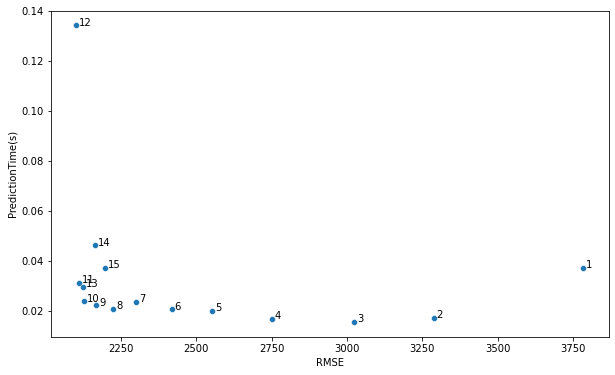

In [39]:
fig, axs = plt.subplots(figsize=(10, 6))

sns.scatterplot(data=tree_results, x='RMSE', y='PredictionTime(s)', legend=False)

for count in tree_results.index:
    
    plt.text(x = tree_results.loc[count]['RMSE'] + 10 , 
             y = tree_results.loc[count]['PredictionTime(s)'] , 
             s = str(count))

Gráfico de Tiempo de predicción contra RECM para diferentes profundidades máximas del árbol. El objetivo del modelo de predicción es minimizar tanto el error como el tiempo de predicción, por lo que podemos visualizar el parámetro más óptimo como el que esté más cerca del origen en esta gráfica. 

Se puede observar que a partir de 9 de produndidad máxima, el modelo no disminuye significativamente el error, pero sí aumenta su tiempo de predicción. 

Si se desea priorizar la precisión la profundidad máxima óptima es de 12, aunque 9 o 10 también muestran un error bajo con tiempo de predicción aún menor. Por lo tanto en este caso se elige el valor 12 como el hiperparámetro más adecuado.

Se guardan los resultados del árbol con menor error como referencia.

In [40]:
best_depth = tree_results[tree_results['RMSE']==tree_results['RMSE'].min()].index

validation.loc['DecisionTreeRegressor'] = tree_results.loc[best_depth].values

In [41]:
validation.head(2)

,TrainingTime(s),PredictionTime(s),RMSE,R2score
LinearRegression,25.3866,0.425113,2832.17,0.602271
DecisionTreeRegressor,5.34806,0.134203,2100.81,0.781162


### Bosque Aleatorio

Basándonos en los resultados anteriores, en este modelo se utilizan 12 nodos de profundidad máxima. Se itera para valores de estimadores desde 10 hasta 100 en intervalos de 10.

In [42]:
forest_results = pd.DataFrame(columns=metrics, index=range(10, 101, 10))
forest_results.index.name = 'Estimators'

for est in forest_results.index:
    
    forest = RandomForestRegressor(n_estimators=est, max_depth=12 , random_state=12345)
    
    forest_results.loc[est]= train_predict_evaluate(forest, X_train_enc, y_train, X_valid_enc, y_valid)

Se muestran los resultados.

In [43]:
forest_results

,TrainingTime(s),PredictionTime(s),RMSE,R2score
Estimators,,,,
10,26.3713,0.196056,1918.67,0.817464
20,53.7452,0.408001,1905.53,0.819954
30,82.0178,0.542581,1901.93,0.820635
40,96.8178,0.728765,1898.72,0.821239
50,148.218,0.916205,1897.61,0.821448
60,142.411,1.09316,1896.73,0.821613
70,165.585,1.24909,1895.99,0.821753
80,191.537,1.43933,1895.04,0.821931
90,234.499,1.59108,1893.7,0.822184


Los resultados más reelevantes se pueden observar en la siguiente gráfica.

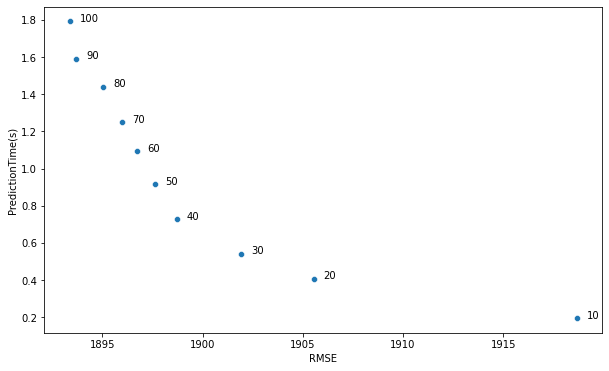

In [44]:
fig, axs = plt.subplots(figsize=(10, 6))

sns.scatterplot(data=forest_results, x='RMSE', y='PredictionTime(s)', legend=False)

for est in forest_results.index:
    
    plt.text(x = forest_results.loc[est]['RMSE'] + 0.5 , 
             y = forest_results.loc[est]['PredictionTime(s)'] , 
             s = str(est))

Gráfico de tiempo de predicción contra RECM para número de estimadores. Todos los bosques, sin importar el número de estimadores tienen menor error que los modelos anteriores, sin embargo presentan un tiempo de predicción considerablemente mayor.

Igual que en el caso anterior, el número óptimo de estimadores debería estar cerca del origen en la gráfica, pues esto minimiza tanto el error como el tiempo de predicción. Sin embargo, en este caso existe un sacrificio entre el tiempo y la precisión; si intentamos minimizar el error aumenta el tiempo de predicción, mientras que al disminuir el tiempo de predicción aumenta el error. Por lo tanto es importante definir el peso que tiene cada uno de estos aspectos en el modelo final.

Por el momento, si damos más prioridad a la precisión, un buen compromiso parecen ser 80 estimadores.

Se guarda el bosque con menor error para referencias futuras.

In [45]:
best_est = forest_results[forest_results['RMSE']==forest_results['RMSE'].min()].index
validation.loc['RandomForestRegressor'] = forest_results.loc[best_est].values

In [46]:
validation.head(3)

,TrainingTime(s),PredictionTime(s),RMSE,R2score
LinearRegression,25.3866,0.425113,2832.17,0.602271
DecisionTreeRegressor,5.34806,0.134203,2100.81,0.781162
RandomForestRegressor,236.448,1.79158,1893.36,0.822247


### Potenciación de Gradiente

Existen muchos hiperparámetros que se pueden modificar con este método. En este trabajo nos enfocamos en dos de los más básicos: número de rondas y número de hojas. A grandes rasgos, el algoritmo utilizado en LightGBM crece aumentando su profundidad. Esto hace que los resultados converjan de manera más rápida. Una manera de limitar este crecimiento es limitando el número de hojas.

Por esta razón se observan los resultados para número de hojas en un rango de 10 a 50, con incrementos de 10.

Para cada uno de estos se modifica el número de rondas, en un rango de 50 hasta 100 con incrementos de 10.

In [57]:
lgb_results = pd.DataFrame(columns=['Training Time', 'PredictionTime(s)','RMSE', 'R2score', 'Iterations', 'Leaves'], 
                           index=range(1, 26) )

#Se crea un dataset para lgb
lgb_train = lgb.Dataset(X_train_enc , y_train, categorical_feature=categoric)

count=1
for r in range(50, 101, 10):
    for l in range(10, 51, 10):
        params = {
            "boosting_type": "gbdt", #Gradient Boosting Decision Tree
            "objective": "regression", #La función objetivo es rmse
            "num_rounds": r, #iteramos este parámetro 
            "num_leaves": l, # iteramos este parámetro          
        }

        # Entrenamiento
        start_time = time.time()
        gbm = lgb.train(params, lgb_train, categorical_feature=categoric)
        train_time = time.time()

        # Predicción
        predicted_valid = gbm.predict(X_valid_enc)
        prediction_time = time.time()

        # Evaluación
        rmse, r2 = evaluate(y_valid, predicted_valid)

        #tiempos de entrenamiento y predicción
        ttime = train_time - start_time
        ptime = prediction_time - train_time

        results = [ttime, ptime, rmse, r2, r, l]
    
        lgb_results.loc[count] = results
        count += 1

/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Foun

Para visualizar la relación entre número de hojas y número de rondas, se muestran los mapas de calor para los valores de RECM y tiempo de predicción.

Text(0.5, 1.0, 'Prediction Time(s)')

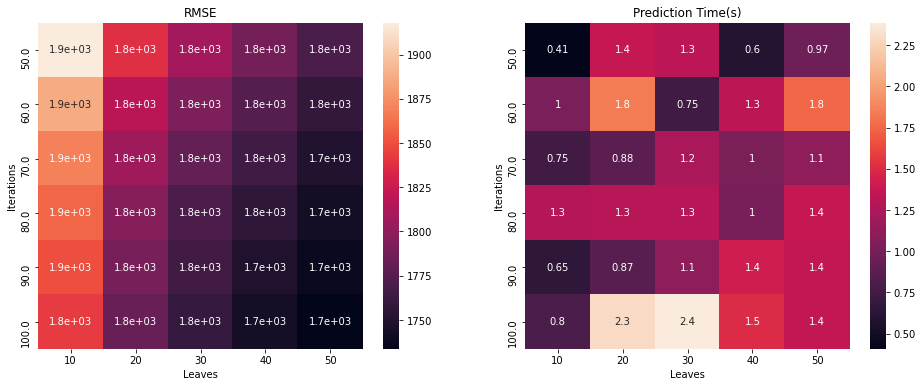

In [59]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 6))

rsme_heat = pd.pivot(lgb_results, values='RMSE', index='Iterations', columns='Leaves')
sns.heatmap(rsme_heat.astype(float), annot=True, ax=ax0 )
ax0.set_title('RMSE')

ptime_heat = pd.pivot(lgb_results, values='PredictionTime(s)', index='Iterations', columns='Leaves')
sns.heatmap(ptime_heat.astype(float), annot=True, ax=ax1)
ax1.set_title('Prediction Time(s)')

Diagramas de calor de Número de iteraciones contra número de hojas. A la izquierda se muestra el valor de RMSE, a la derecha el tiempo de predicción. Cuanto más oscuro el color se minimiza tanto el error como el tiempo de predicción. 

El diagrama de la izquierda muestra que cuanto más altos son el número de iteraciones y número de hojas menor es el error. Por otro lado cuanto más bajo es el número de iteradores y hojas menor el tiempo de predicción.

Se muestran los valores que tienen menor error que el mejor resultado del bosque de decisión y cuyo tiempo de predicción es menor a 1 segundo 

In [49]:
lgb_results[(lgb_results['RMSE']<1895) & (lgb_results['PredictionTime(s)']<1)].sort_values(by='RMSE')

,Training Time,PredictionTime(s),RMSE,R2score,Iterations,Leaves
14,5.51176,0.973357,1764.96,0.845538,70,40
5,4.56061,0.705385,1769.87,0.844679,50,50
18,5.89509,0.995948,1770.64,0.844543,80,30
9,4.22165,0.723369,1775.32,0.84372,60,40
13,4.77941,0.77462,1781.92,0.842556,70,30
4,3.87917,0.777009,1788.99,0.841303,50,40
8,3.65152,0.644353,1792.45,0.840689,60,30
17,4.74059,0.776413,1796.04,0.840051,80,20
12,4.19126,0.721601,1806.11,0.838252,70,20
3,3.83556,0.6836,1808.09,0.837897,50,30


Se guardan los resultados del modelo con menor RECM.

In [83]:
best_ind = lgb_results[lgb_results['RMSE']==lgb_results['RMSE'].min()].index
validation.loc['GradientBoosting'] = lgb_results.iloc[best_ind-1, 0:4].values

<AxesSubplot:xlabel='RMSE', ylabel='PredictionTime(s)'>

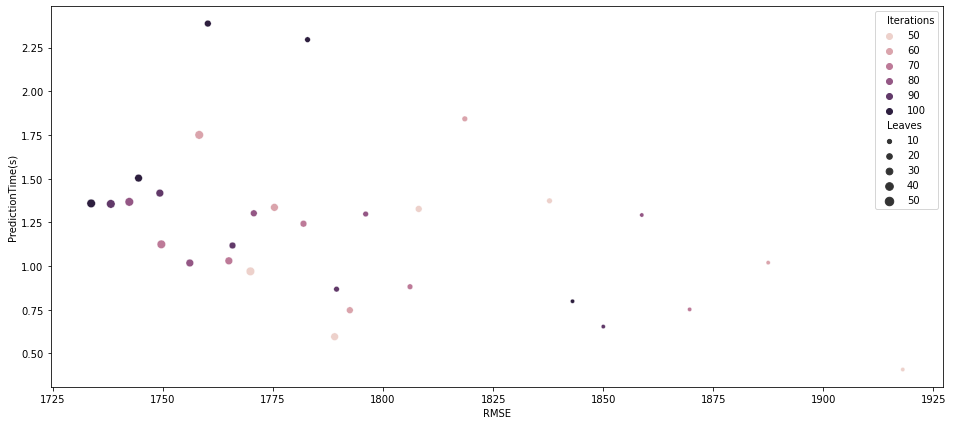

In [84]:
fig, axs = plt.subplots(figsize=(16, 7))

sns.scatterplot(data=lgb_results, x='RMSE', y='PredictionTime(s)', hue='Iterations', size='Leaves' )

Gráfico de Tiempo de Predicción contra RMSE para ensambles con diferente número de hojas e iteraciones. Se puede observar que a mayor número de iteradores disminuye el error,  pero no necesariamente a mayor número de hojas disminuye el error. 

Para tener una noción de la calidad de todos los modelos se muestra el siguiente gráfico.

<AxesSubplot:xlabel='RMSE', ylabel='PredictionTime(s)'>

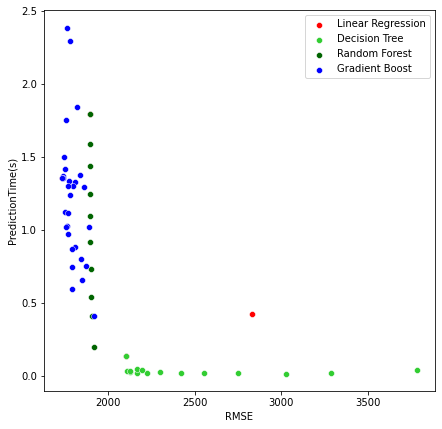

In [85]:
fig, ax = plt.subplots(figsize=(7, 7))

#regresión lineal

sns.scatterplot(data=validation, x='RMSE', y='PredictionTime(s)', color='red', label='Linear Regression')

#árbol
sns.scatterplot(data=tree_results, x='RMSE', y='PredictionTime(s)', color='limegreen', label='Decision Tree')

#bosque
sns.scatterplot(data=forest_results, x='RMSE', y='PredictionTime(s)', color='darkgreen', label='Random Forest')

#potenciación de gradiente
sns.scatterplot(data=lgb_results, x='RMSE', y='PredictionTime(s)', color='blue', label='Gradient Boost')

Gráfico de Tiempo de Predicción contra RMSE para todos los modelos. En rojo se muestra la predicción con el modelo de regresión lineal. 

Lo primero que se puede observar es que todos los modelos parecen tener un límite en su precisión, de tal manera que al modificar los hiperparámetros la ganancia en precisión es muy pequeña. 

Cada modelo ofrece ciertas ventajas sobre los demás, por ejemplo, los árboles de decisión toman un tiempo de predicción muy bajo en comparación con los demás modelos, sin embargo tienen un límite en su precisión. 

Por otro lado los bosques aleatorios ofrecen una precisión muy focalizada, pero difieren mucho en el tiempo de predicción.

Los ensambles por potenciación de gradiente ofrecen la mayor precisión de todos los modelos, y un tiempo de predicción comparable a los bosques. 

## Análisis de los modelos finales

Finalmente, se hacen predecciones para el conjunto de prueba de los modelos con los mejores hiperparámetros.

In [52]:
#regresión lineal
test = pd.DataFrame( columns=metrics, index=models)
test.loc['LinearRegression'] = train_predict_evaluate(lr, X_train_ohe, y_train, X_test_ohe, y_test)

# árbol de decisión
tree = DecisionTreeRegressor(max_depth=12 , random_state=12345)
test.loc['DecisionTreeRegressor']= train_predict_evaluate(tree, X_train_enc, y_train, X_test_enc, y_test)

#bosque aleaorio
forest = RandomForestRegressor(n_estimators=80, max_depth=12 , random_state=12345)    
test.loc['RandomForestRegressor']= train_predict_evaluate(forest, X_train_enc, y_train, X_test_enc, y_test)

In [86]:
#potenciación de gradiente
params = {"boosting_type": "gbdt", #Gradient Boosting Decision Tree
          "objective": "regression", #La función objetivo es rmse
          "num_rounds": 100, #el valor óptimo obtenido
          "num_leaves": 30, # el valor óptimo obtenido
          }

# Entrenamiento
start_time = time.time()
gbm = lgb.train(params, lgb_train, categorical_feature=categoric)
train_time = time.time()

# Predicción
predicted_valid = gbm.predict(X_test_enc)
prediction_time = time.time()

# Evaluación
rmse, r2 = evaluate(y_test, predicted_valid)

#tiempos de entrenamiento y predicción
ttime = train_time - start_time
ptime = prediction_time - train_time

test.loc['GradientBoosting'] = [ttime, ptime, rmse, r2]

/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Se muestran los resultados para el conjunto de prueba.

In [87]:
test

,TrainingTime(s),PredictionTime(s),RMSE,R2score
LinearRegression,23.8296,0.511344,2844.2,0.600726
DecisionTreeRegressor,3.1215,0.0509412,2117.2,0.778755
RandomForestRegressor,211.697,1.4711,1917.88,0.81845
GradientBoosting,8.13421,1.14999,1786.36,0.842497


Las mejores métricas se obtienen con potenciación de gradiente, aunque tiene el segundo tiempo de predicción más alto. El mayor tiempo de entrenamiento y predicción lo tiene el bosque aleatorio. El modelo más rápido es el árbol de decisión. 

In [88]:
total = test.merge(validation, how='outer', on=test.index, suffixes=('_test', '_valid'))

In [89]:
total

,key_0,TrainingTime(s)_test,PredictionTime(s)_test,RMSE_test,R2score_test,TrainingTime(s)_valid,PredictionTime(s)_valid,RMSE_valid,R2score_valid
0,LinearRegression,23.8296,0.511344,2844.2,0.600726,25.3866,0.425113,2832.17,0.602271
1,DecisionTreeRegressor,3.1215,0.0509412,2117.2,0.778755,5.34806,0.134203,2100.81,0.781162
2,RandomForestRegressor,211.697,1.4711,1917.88,0.81845,236.448,1.79158,1893.36,0.822247
3,GradientBoosting,8.13421,1.14999,1786.36,0.842497,12.3337,1.35843,1733.7,0.850962


Los resultados del conjunto de validación y el de prueba son congruentes y no hay diferencias significativas en ninguna métrica. Todos los modelos tienen errores más altos en el conjunto de prueba que en el de validación, pero no demasiado, lo cual indica que no hay tanto sobreajuste. 

## Conclusiones

Con el objetivo de encontrar un modelo de predicción de precios de autos con la mayor precisión y menor tiempo de predicción se analizaron cuatro modelos: Regresión Lineal, Árbol de Decisión, Bosque Aleatorio y Potenciación de Gradiente. 

Para el método de Regresión Lineal se reaizó un escalado de características con el algoritmo MinMaxScaler, y los datos categóricos se codificaron con el método One-Hot, se descartó una columna del entrenamiento, pues debido a su alta cardinalidad hubiera requerido un exceso de recursos computacionales.

Para el resto de los modelos se utilizó una codificación de etiquetas.

Se realizó una optimización de los siguientes hiperparámetros: profundidad máxima para Árbol de Decisión, número de estimadores para Bosque Aleatorio, número de hojas y número de rondas para Potenciación de Gradiente. Para evaluar la calidad de los modelos se calcularon las métricas RECM y score R2, así como el Tiempo de predicción y Tiempo de entrenamiento. Esto se realizó para cada uno de los modelos con los rangos de parámetros a investigar.

Para seleccionar los hiperparámetros más adecuados, se realizaron gráficas de dispersión de Tiempo de Predicción contra RECM. Este tipo de gráfica permite visualizar cuál es el valor del hiperparámetro que minimiza simultáneamente estos aspectos del modelo. 

Adicionalmente se realizaron dos gráficas de calor con valores de RECM y Tiempo de predicción para todos los valores de hojas y rondas.

Posteriormente se hizo una gráfica de dispersión comparativa de todos los modelos. Todos los modelos parecen tener un límite en su precisión, de tal manera que al modificar los hiperparámetros la ganancia en precisión es muy pequeña.

Cada modelo ofrece ciertas ventajas sobre los demás, por ejemplo, los árboles de decisión toman un tiempo de predicción muy bajo en comparación con los demás modelos, sin embargo tienen un límite en su precisión.

Por otro lado los bosques aleatorios ofrecen una precisión muy focalizada, pero difieren mucho en el tiempo de predicción.

Los ensambles por potenciación de gradiente ofrecen la mayor precisión de todos los modelos, y un tiempo de predicción menor o comparable a los bosques.

Una vez definidos los modelos con los parámetros óptimos, se realizaron predicciones al conjunto de prueba.

Las mejores métricas se obtienen con potenciación de gradiente, aunque tiene el segundo tiempo de predicción más alto. El mayor tiempo de entrenamiento y predicción lo tiene el bosque aleatorio. El modelo más rápido es el árbol de decisión. 

Los resultados del conjunto de validación y el de prueba son congruentes y no hay diferencias significativas en ninguna métrica. Todos los modelos tienen errores más altos en el conjunto de prueba que en el de validación, pero no demasiado, lo cual indica que no hay tanto sobreajuste. 

En conclusión el modelo con mejor desempeño es con Potenciación de Gradiente.

# Lista de control

Escribe 'x' para verificar. Luego presiona Shift+Enter

- [x]  Jupyter Notebook está abierto
- [ ]  El código no tiene errores- [ ]  Las celdas con el código han sido colocadas en orden de ejecución- [ ]  Los datos han sido descargados y preparados- [ ]  Los modelos han sido entrenados
- [ ]  Se realizó el análisis de velocidad y calidad de los modelos